<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>

# <center>Идентификация пользователей по посещенным веб-страницам

**Импортирование требуемых библиотек**

In [135]:
import os
import pickle

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

from scipy.sparse import csr_matrix, coo_matrix, hstack

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from hyperopt import fmin, hp, tpe, Trials

from tqdm import tqdm_notebook, tqdm, trange

from operator import itemgetter

import warnings
warnings.filterwarnings('ignore')

### **Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки)**

**Описание данных**

В обучающей выборке train_sessions.csv признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl).
Признаки time_j – время посещения сайтов site_j.

Целевой признак target – факт того, что сессия принадлжит Элис (то есть что именно Элис ходила по всем этим сайтам).

Задача – сделать прогнозы для сессий в тестовой выборке (test_sessions.csv), определить, принадлежат ли они Элис.

Не обязательно ограничиваться только предложенной выборкой train_sessions.csv – в train.zip даны исходные данные о посещенных пользователями веб-страницах, по которым можно сформировать свою обучающую выборку.

Train set train_sessions.csv contains information on user browsing sessions where the features are:

site_i – are ids of sites in this session. The mapping is given with a pickled dictionary site_dic.pkl.

time_j – are timestamps of attending the corresponding site.

target – whether this session belongs to Alice.

One can use original data train.zip to form a train set differing from train_sessions.csv.

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('../Week 5 SGD and Kaggle/data/')

In [20]:
time_cols = ['time1', 'time2', 'time3', 'time4', 'time5',
             'time6', 'time7', 'time8', 'time9', 'time10']

In [21]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id', parse_dates=time_cols)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id', parse_dates=time_cols)

In [22]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [31]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


### Первичный анализ данных

**Отсортируем данные по времени**

In [23]:
train_df_sorted = train_df.sort_values('time1')

In [36]:
train_als = train_df_sorted.copy()
test_als = test_df.copy()
train_als['year'] = train_df_sorted['time1'].apply(lambda x: x.year)
test_als['year'] = test_df['time1'].apply(lambda x: x.year)

**Распределение лет трейн/тест**

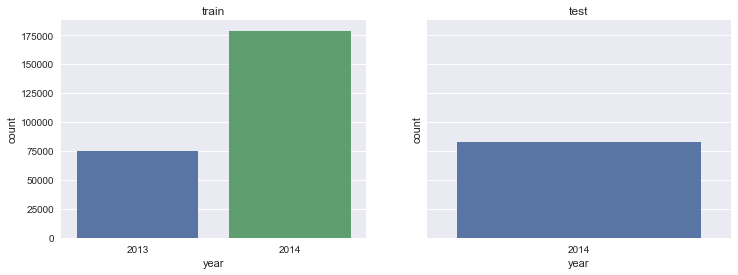

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.countplot(train_als['year'], ax=ax1)
ax1.set_title('train')
sns.countplot(test_als['year'], ax=ax2)
ax2.set_title('test');

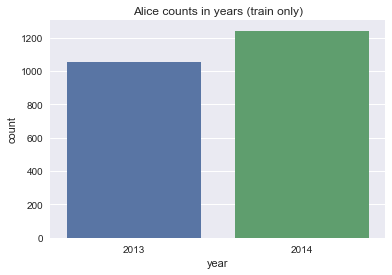

In [38]:
sns.countplot(train_als['year'][train_als['target'] == 1])
plt.title('Alice counts in years (train only)');

**Распределение месяцев трейн/тест**

In [39]:
train_als['month'] = train_als['time1'].apply(lambda x: x.month)
test_als['month'] = test_als['time1'].apply(lambda x: x.month)

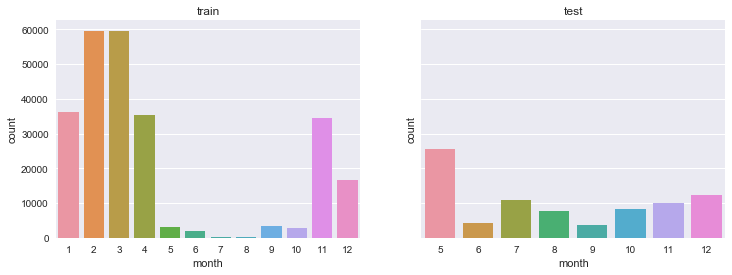

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.countplot(train_als['month'], ax=ax1)
ax1.set_title('train')
sns.countplot(test_als['month'], ax=ax2)
ax2.set_title('test');

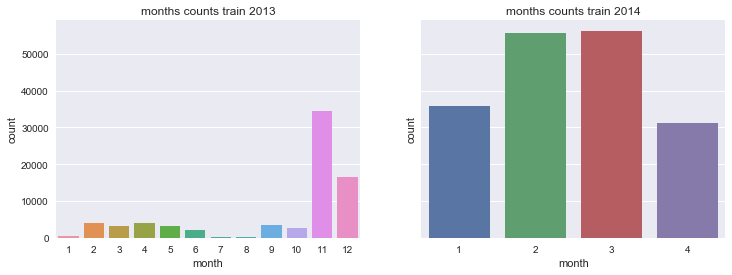

In [41]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.countplot(train_als['month'][train_als['year'] == 2013], ax=ax1)
ax1.set_title('months counts train 2013')
sns.countplot(train_als['month'][train_als['year'] == 2014], ax=ax2)
ax2.set_title('months counts train 2014');

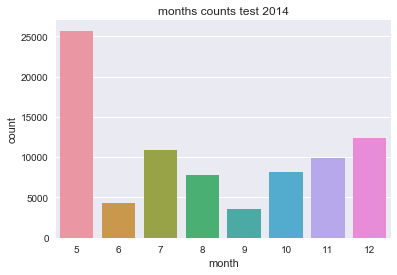

In [42]:
sns.countplot(test_als['month'])
plt.title('months counts test 2014');

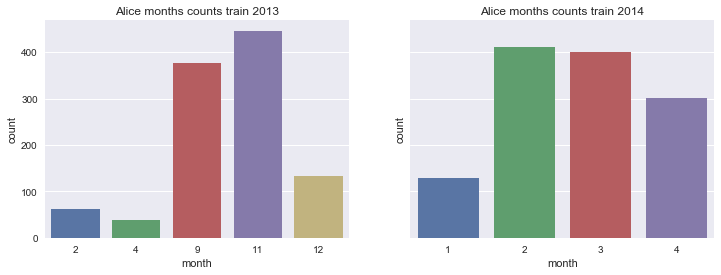

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.countplot(train_als['month'][train_als['year'] == 2013][train_als['target'] == 1], ax=ax1)
ax1.set_title('Alice months counts train 2013')
sns.countplot(train_als['month'][train_als['year'] == 2014][train_als['target'] == 1], ax=ax2)
ax2.set_title('Alice months counts train 2014');

In [44]:
del train_df_sorted, train_als, test_als

**Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.**

In [45]:
train_test_df = pd.concat([train_df, test_df])

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

**Посмотрим на статистику признаков.**

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [46]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null datetime64[ns]
site2     250098 non-null float64
time2     250098 non-null datetime64[ns]
site3     246919 non-null float64
time3     246919 non-null datetime64[ns]
site4     244321 non-null float64
time4     244321 non-null datetime64[ns]
site5     241829 non-null float64
time5     241829 non-null datetime64[ns]
site6     239495 non-null float64
time6     239495 non-null datetime64[ns]
site7     237297 non-null float64
time7     237297 non-null datetime64[ns]
site8     235224 non-null float64
time8     235224 non-null datetime64[ns]
site9     233084 non-null float64
time9     233084 non-null datetime64[ns]
site10    231052 non-null float64
time10    231052 non-null datetime64[ns]
target    253561 non-null int64
dtypes: datetime64[ns](10), float64(9), int64(2)
memory usage: 42.6 MB


In [47]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [48]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null datetime64[ns]
site2     81308 non-null float64
time2     81308 non-null datetime64[ns]
site3     80075 non-null float64
time3     80075 non-null datetime64[ns]
site4     79182 non-null float64
time4     79182 non-null datetime64[ns]
site5     78341 non-null float64
time5     78341 non-null datetime64[ns]
site6     77566 non-null float64
time6     77566 non-null datetime64[ns]
site7     76840 non-null float64
time7     76840 non-null datetime64[ns]
site8     76151 non-null float64
time8     76151 non-null datetime64[ns]
site9     75484 non-null float64
time9     75484 non-null datetime64[ns]
site10    74806 non-null float64
time10    74806 non-null datetime64[ns]
dtypes: datetime64[ns](10), float64(9), int64(1)
memory usage: 15.8 MB


**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [49]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

**Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [50]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [51]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


In [52]:
print('Shape of train_test_df_sites array: {}'.format(train_test_df_sites.shape))
print('Number of unique sites: {}'.format(len(np.unique(train_test_df_sites.values)) - 1))

Shape of train_test_df_sites array: (336358, 10)
Number of unique sites: 48371


### **Создадим разреженные матрицы *X_train_sparse* и *X_test_sparse*. Сначала создадим объединенную матрицу *train_test_df_sites*, потом разделим обратно на обучающую и тестовую части.**

В сессиях меньше 10 сайтов у нас остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом $i$). Поэтому первый столбец разреженной матрицы надо удалить.

**Выделим в отдельный вектор *y* ответы на обучающей выборке.**

In [53]:
def dropcols_coo(C, idx_to_drop):
    idx_to_drop = np.unique(idx_to_drop)
    keep = ~np.in1d(C.col, idx_to_drop)
    C.data, C.row, C.col = C.data[keep], C.row[keep], C.col[keep]
    C.col -= idx_to_drop.searchsorted(C.col)    # decrement column indices
    C._shape = (C.shape[0], C.shape[1] - len(idx_to_drop))
    return C

In [54]:
def transform_to_csr_matrix(arr):
    rows = []
    columns = []
    data = []
    for i in range(arr.shape[0]):
        # Create dictionary {site: number of visits per session}
        unique, counts = np.unique(arr[i], return_counts=True)
        dic = dict(zip(unique, counts))
        rows.extend([i]*len(dic.keys()))
        columns.extend(dic.keys())
        data.extend(dic.values())
    
    # Sparse coo matrix
    arr_new_coo = coo_matrix((data, (rows, columns)))
    
    # Drop column with "zero" site and transform to csr
    return dropcols_coo(arr_new_coo, 0).tocsr()

In [70]:
# Transform train_test_df_sites to sparse format
train_test_sparse_sites = transform_to_csr_matrix(train_test_df_sites.values)

In [71]:
print('Shape of train_test_sparse array: {}'.format(train_test_sparse.get_shape()))

Shape of train_test_sparse array: (336358, 48371)


**Разделим матрицу на train и test.**

In [73]:
# Split train_test_df_sites on X_train, X_test, y
X_train_sparse_sites = train_test_sparse_sites[:train_df.shape[0]]
X_test_sparse_sites = train_test_sparse_sites[train_df.shape[0]:]
y = train_df['target']

print('Shape of X_train_sparse_sites array: {}'.format(X_train_sparse_sites.get_shape()))
print('Shape of X_test_sparse_sites array: {}'.format(X_test_sparse_sites.get_shape()))
print('Shape of y array: {}'.format(y.shape))

Shape of X_train_sparse_sites array: (253561, 48371)
Shape of X_test_sparse_sites array: (82797, 48371)
Shape of y array: (253561,)


**Сохраним в pickle-файлы объекты *X_train_sparse*, *X_test_sparse* и *y* (последний – в файл *kaggle_data/train_target.pkl*).**

In [74]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse_sites.pkl'), 'wb') as X_train_sparse_sites_pkl:
    pickle.dump(X_train_sparse_sites, X_train_sparse_sites_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse_sites.pkl'), 'wb') as X_test_sparse_sites_pkl:
    pickle.dump(X_test_sparse_sites, X_test_sparse_sites_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'wb') as train_target_pkl:
    pickle.dump(y, train_target_pkl, protocol=2)

### Разделение на train и valid

**Разобьем обучающую выборку на 2 части в пропорции 75/25. Для выделения общих закономерностей перемешаем данные. На соревновании так можно получить высокий скор.**

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse_sites, y,
                                                      test_size=0.25, shuffle=True, random_state=42)

### Over-sampling для sgd-classifier.

In [76]:
%%time
from imblearn.over_sampling import SMOTE, ADASYN

sm = SMOTE(random_state=42, ratio='minority', n_jobs=4)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

CPU times: user 1min 9s, sys: 212 ms, total: 1min 9s
Wall time: 1min 9s


In [77]:
train_share = X_train_res.shape[0]
train_share

376892

### Обучение бейзлайна с помощью SGDClassifier и logit

**Создадим объект `sklearn.linear_model.SGDClassifier` с логистической функцией потерь и параметром *random_state*=42. Остальные параметры оставим по умолчанию. Обучим  модель на выборке `(X_train, y_train)`.**

In [78]:
%%time
sgd_logit = SGDClassifier(loss='log', random_state=42, n_jobs=-1)
sgd_logit.fit(X_train_res, y_train_res)

CPU times: user 1.1 s, sys: 8 ms, total: 1.11 s
Wall time: 514 ms


In [81]:
%%time
logit = LogisticRegression(random_state=42, n_jobs=-1)
logit.fit(X_train_res, y_train_res)

CPU times: user 34.7 s, sys: 744 ms, total: 35.4 s
Wall time: 8.94 s


**Сделаем прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)* и посчитаем roc-auc.**

In [82]:
sgd_logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)

roc_auc_sgd_logit = roc_auc_score(y_valid, sgd_logit_valid_pred_proba[:, 1])
print('ROC AUC score: {:.5f}'.format(roc_auc_sgd_logit))

ROC AUC score: 0.95746


In [83]:
logit_valid_pred_proba = logit.predict_proba(X_valid)

roc_auc_logit = roc_auc_score(y_valid, logit_valid_pred_proba[:, 1])
print('ROC AUC score: {:.5f}'.format(roc_auc_logit))

ROC AUC score: 0.95826


In [92]:
c1 = 0.35
final = c1*sgd_logit_valid_pred_proba[:, 1] + (1 - c1)*logit_valid_pred_proba[:, 1]
roc_auc_final = roc_auc_score(y_valid, final)
print('ROC AUC score: {:.5f}'.format(roc_auc_final))

ROC AUC score: 0.96135


**Сделаем прогноз в виде предсказанных вероятностей отнесения к классу 1 для тестовой выборки с помощью той же *sgd_logit*, обученной уже на всей обучающей выборке (а не на 75%).**

In [93]:
%%time
sgd_logit.fit(X_train_sparse_sites, y)
sgd_logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse_sites)

CPU times: user 928 ms, sys: 12 ms, total: 940 ms
Wall time: 339 ms


In [94]:
%%time
logit.fit(X_train_sparse_sites, y)
logit_test_pred_proba = logit.predict_proba(X_test_sparse_sites)

CPU times: user 18.2 s, sys: 412 ms, total: 18.6 s
Wall time: 4.69 s


### Запись файла с ответами

In [95]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
write_to_submission_file(logit_test_pred_proba[:, 1], 'submissions/res_1_logit.csv')

### **Настроим параметры модели**

**Кросс-валидация**

In [98]:
cv_iterator = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [99]:
%%time
logit = LogisticRegression(C=1,
                           class_weight=None,
                           random_state=42)

cv_score = cross_val_score(logit, X_train, y_train, scoring='roc_auc', cv=cv_iterator, n_jobs=-1)
score = np.mean(cv_score)
print(cv_score)
print(score)

[ 0.95595464  0.95741994  0.96165029  0.96303308  0.95485046]
0.958581680576
CPU times: user 240 ms, sys: 76 ms, total: 316 ms
Wall time: 9.64 s


In [100]:
def hyperopt_objective(params):
    global HYPEROPT_CNT
    logit = LogisticRegression(C=params['C'], random_state=42)

    score = np.mean(cross_val_score(logit, X_train, y_train,
                                    scoring='roc_auc', cv=cv_iterator, n_jobs=-1))
    
    print('#{:3d} score: {:.5f} params:{}'.format(HYPEROPT_CNT, score, params))
    HYPEROPT_CNT += 1
    return 1 - score #hyperopt minimizes

In [103]:
param_space = {
    #'penalty': hp.choice('penalty', ('l1', 'l2')),
    'C': hp.uniform('C', 0, 5),
    #'class_weight': hp.choice('class_weight', (None, 'balanced'))
}

In [104]:
%%time
HYPEROPT_CNT = 0
trials = Trials()

best_params = fmin(
    hyperopt_objective,
    space=param_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials
)

#  0 score: 0.95877 params:{'C': 1.3444658145782769}
#  1 score: 0.95864 params:{'C': 1.061780377071217}
#  2 score: 0.95861 params:{'C': 2.688381281008692}
#  3 score: 0.95869 params:{'C': 2.3930937992906447}
#  4 score: 0.95751 params:{'C': 0.5368055870365845}
#  5 score: 0.95880 params:{'C': 1.8525216015514612}
#  6 score: 0.95626 params:{'C': 0.35537891067606187}
#  7 score: 0.95799 params:{'C': 4.733841035063292}
#  8 score: 0.95850 params:{'C': 3.1150627759217335}
#  9 score: 0.95812 params:{'C': 4.290843775284091}
CPU times: user 2.34 s, sys: 744 ms, total: 3.08 s
Wall time: 2min 12s


In [105]:
print(best_params)

{'C': 1.8525216015514612}


**Оценим качество модели на отложенной выборке**

In [106]:
logit = LogisticRegression(C=1.6007953141709625, random_state=42)

logit.fit(X_train, y_train)

LogisticRegression(C=1.6007953141709625, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [107]:
logit_valid_pred_proba = logit.predict_proba(X_valid)

roc_auc_logit = roc_auc_score(y_valid, logit_valid_pred_proba[:, 1])
print('ROC AUC score: {:.5f}'.format(roc_auc_logit))

ROC AUC score: 0.96506


### Добавим новые фичи в модель

**Создадим словарь с частотами посещения сайтов.**

In [108]:
def prepare_site_dict(df):
    columns = ['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10']
    vals, cnts = np.unique(df[columns].fillna(0).values, return_counts=True)
    site_dict = dict(zip(vals.astype(int), cnts.astype(int)))
    if 0 in site_dict:
        del site_dict[0]
    return site_dict

In [109]:
site_freq_alice = prepare_site_dict(train_df)

In [110]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_alice.pkl'), 'wb') as site_freq_alice_pkl:
    pickle.dump(site_freq_alice, site_freq_alice_pkl, protocol=2)

**Отсортируем колонки массива для облегчения дальнейшей обработки.**

In [112]:
%%time
site_cols = ['site%d' % i for i in range(1, 11)]
time_cols = ['time%d' % i for i in range(1, 11)]

train_test_df_full = train_test_df[site_cols + time_cols].copy()
train_test_df_full[site_cols] = train_test_df_full[site_cols].fillna(0).astype(int)

CPU times: user 60 ms, sys: 16 ms, total: 76 ms
Wall time: 74.4 ms


In [113]:
print(train_test_df_full.shape)
train_test_df_full.head()

(336358, 20)


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0,2014-02-20 10:02:45,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,890,941,3847,941,942,3846,3847,3846,1516,1518,2014-02-22 11:19:50,2014-02-22 11:19:50,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:52,2014-02-22 11:19:52,2014-02-22 11:20:15,2014-02-22 11:20:16
3,14769,39,14768,14769,37,39,14768,14768,14768,14768,2013-12-16 16:40:17,2013-12-16 16:40:18,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:20,2013-12-16 16:40:21,2013-12-16 16:40:22,2013-12-16 16:40:24
4,782,782,782,782,782,782,782,782,782,782,2014-03-28 10:52:12,2014-03-28 10:52:42,2014-03-28 10:53:12,2014-03-28 10:53:42,2014-03-28 10:54:12,2014-03-28 10:54:42,2014-03-28 10:55:12,2014-03-28 10:55:42,2014-03-28 10:56:12,2014-03-28 10:56:42
5,22,177,175,178,177,178,175,177,177,178,2014-02-28 10:53:05,2014-02-28 10:55:22,2014-02-28 10:55:22,2014-02-28 10:55:23,2014-02-28 10:55:23,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:57:06,2014-02-28 10:57:11


**Создание новых признаков**

In [117]:
def prepare_train_set_with_fe(df):
    df_new_feat = pd.DataFrame(index=df.index)
    
    session_window = 10
    
    time_diff = np.zeros( (df.shape[0], (session_window - 1)), dtype=int)
    session_timespan = []
    num_of_unique_sites = []
    start_hour = []
    day_of_week = []
    
    site_cols = ['site%d' % i for i in range(1, 11)]
    time_cols = ['time%d' % i for i in range(1, 11)]
    
    site_list = df[site_cols].values.tolist()
    
    for i, (_, times) in enumerate(tqdm(df[time_cols].iterrows(), total=df.shape[0])):
        sites = site_list[i]
        times_wo_na_df = times.dropna()

        # Fill time_diff FEATURE list
        for j in range(session_window - 1):
            if not pd.isnull(times[j]) and not pd.isnull(times[j + 1]):
                time_diff[i][j] = int( (times[j + 1] - times[j]) / np.timedelta64(1, 's') )
            else:
                break

        # Fill start_hour FEATURE list
        start_hour.append(times_wo_na_df.min().hour)

        # Fill day_of_week FEATURE list
        day_of_week.append(times_wo_na_df.min().dayofweek)

        # Fill num_of_unique_sites FEATURE list
        unique_sites = set(sites)
        try:
            # remove site '0' (no visit) from session
            unique_sites.remove(0)
        except:
            pass
        num_of_unique_sites.append(len(unique_sites))
    
    # Convert features to np.array and adding them to the dataframe
    X_td = np.array(time_diff)
    time_diff_cols = ['time_diff%d' % i for i in range(1, 10)]
    X_td_df = pd.DataFrame(X_td, index=df_new_feat.index, columns=time_diff_cols)
    df_new_feat = pd.concat([df_new_feat, X_td_df], axis=1)
    
    X_nous = np.array(num_of_unique_sites)
    df_new_feat['num_of_unique_sites'] = X_nous
    
    X_sh = np.array(start_hour)
    df_new_feat['start_hour'] = X_sh
    
    X_dow = np.array(day_of_week)
    df_new_feat['day_of_week'] = X_dow
    
    # Convert 'time1' to [year][month] FEATURE (ex. 2017-02 -> 201702)
    df_new_feat['year_month_to_num'] = df['time1'].apply(lambda x: 100*x.year + x.month)
    
    return df_new_feat

In [118]:
train_test_df_feat = prepare_train_set_with_fe(train_test_df_full)

with open(os.path.join(PATH_TO_DATA, 'X_new_features.pkl'), 'wb') as X_new_features_pkl:
    pickle.dump(train_test_df_feat, X_new_features_pkl, protocol=2)

100%|██████████| 336358/336358 [05:06<00:00, 1096.06it/s]


In [119]:
with open(os.path.join(PATH_TO_DATA, 'X_new_features.pkl'), 'rb') as X_new_features_pkl:
    train_test_df_feat = pickle.load(X_new_features_pkl)

In [122]:
%%time
site_freq_top = sorted(site_freq_alice.items(), key=itemgetter(1), reverse=True)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 13 ms


In [123]:
time_diff_cols = ['time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5',
                  'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9']

In [124]:
train_test_df_feat.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,num_of_unique_sites,start_hour,day_of_week,year_month_to_num
session_id,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,1,10,3,201402
2,0,1,0,0,0,1,0,23,1,7,11,5,201402
3,1,1,0,0,0,1,1,1,2,4,16,0,201312
4,30,30,30,30,30,30,30,30,30,1,10,4,201403
5,137,0,1,0,36,0,0,67,5,4,10,4,201402


In [125]:
%%time
train_test_df_feat_ohe = pd.get_dummies(train_test_df_feat,
                                        columns=['start_hour', 'day_of_week', 'year_month_to_num'],
                                        sparse=True, drop_first=True)

CPU times: user 1.62 s, sys: 40 ms, total: 1.66 s
Wall time: 1.67 s


**Обучение модели с использованием новых признаков**

In [126]:
site_cols = ['site1', 'site2', 'site3', 'site4', 'site5',
             'site6', 'site7', 'site8', 'site9', 'site10']

time_cols = ['time1', 'time2', 'time3', 'time4', 'time5',
             'time6', 'time7', 'time8', 'time9']

features_cols = list(set(train_test_df_feat_ohe.columns) - set(site_cols) - set(time_diff_cols) -
                set(['num_of_unique_sites']))

In [127]:
train_test_df_feat_ohe = train_test_df_feat_ohe[features_cols].values

X_train_features = train_test_df_feat_ohe[:train_df.shape[0]]
X_test_features = train_test_df_feat_ohe[train_df.shape[0]:]

**Baseline только на сайтах**

In [128]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse_sites, y,
                                                      test_size=0.25, shuffle=True, random_state=42)

In [129]:
%%time
logit = LogisticRegression(C=1.6007953141709625, random_state=42)

base_score = np.mean(cross_val_score(logit, X_train, y_train,
                scoring='roc_auc', cv=cv_iterator, n_jobs=-1))

print('ROC AUC score: {:.5f}'.format(base_score))

ROC AUC score: 0.95880
CPU times: user 324 ms, sys: 72 ms, total: 396 ms
Wall time: 12 s


In [130]:
%%time
logit = LogisticRegression(C=1.6007953141709625, random_state=42)

logit.fit(X_train, y_train)
logit_valid_pred_proba = logit.predict_proba(X_valid)
roc_auc_logit = roc_auc_score(y_valid, logit_valid_pred_proba[:, 1])
print('ROC AUC score: {:.5f}'.format(roc_auc_logit))

ROC AUC score: 0.96506
CPU times: user 15.4 s, sys: 336 ms, total: 15.8 s
Wall time: 4 s


**Проверим модель с новыми признаками на кросс-валидации и валидационной выборке.**

In [141]:
%%time
X_train_features = train_test_df_feat_ohe[:train_df.shape[0]]

scaler = StandardScaler()
X_train_features_sc = scaler.fit_transform(X_train_features)

X_train_sparse = hstack([X_train_sparse_sites, X_train_features_sc]).tocsr()

X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y,
                                                      test_size=0.25, shuffle=True, random_state=42)

logit = LogisticRegression(C=1.6007953141709625, random_state=42)

cv_score = cross_val_score(logit, X_train, y_train,
                scoring='roc_auc', cv=cv_iterator, n_jobs=-1)
roc_auc_cv_logit = np.mean(cv_score)

print(cv_score)
print('ROC AUC score: {:.5f}'.format(roc_auc_cv_logit))

[ 0.9894925   0.99005961  0.98942347  0.98676402  0.98557206]
ROC AUC score: 0.98826
CPU times: user 3.22 s, sys: 460 ms, total: 3.68 s
Wall time: 35.2 s


In [137]:
%%time
logit = LogisticRegression(C=1.6007953141709625, random_state=42)

logit.fit(X_train, y_train)

logit_valid_pred_proba = logit.predict_proba(X_valid)

roc_auc_logit = roc_auc_score(y_valid, logit_valid_pred_proba[:, 1])
print('ROC AUC score: {:.5f}'.format(roc_auc_logit))

ROC AUC score: 0.99158
CPU times: user 35 s, sys: 920 ms, total: 35.9 s
Wall time: 9.05 s


**Построение кривых валидации**

In [143]:
from sklearn.model_selection import learning_curve, validation_curve

def plot_learning_curve(estimator, title, X, y,label_y, ylim=None, cv=None, scoring='roc_auc', 
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(label_y)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 10.3 s, sys: 460 ms, total: 10.8 s
Wall time: 2min 46s


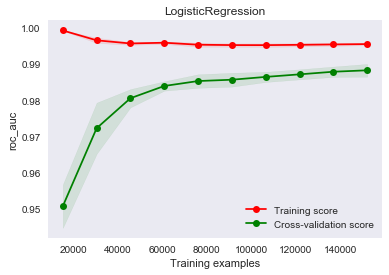

In [144]:
%%time
X_train_features = train_test_df_feat_ohe[:train_df.shape[0]]

scaler = StandardScaler()
X_train_features_sc = scaler.fit_transform(X_train_features)

X_train_sparse = hstack([X_train_sparse_sites, X_train_features_sc]).tocsr()

X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y,
                                                      test_size=0.25, shuffle=True, random_state=42)

plot_learning_curve(LogisticRegression(C=1.6007953141709625, random_state=42), 'LogisticRegression',
                    X_train, y_train, scoring='roc_auc', cv=cv_iterator, n_jobs=-1, label_y='roc_auc')

Видим, что увеличение датасета может привести к более высокому качеству модели.

### Submit

In [139]:
%%time
X_train_features = train_test_df_feat_ohe[:train_df.shape[0]]
X_test_features = train_test_df_feat_ohe[train_df.shape[0]:]

scaler = StandardScaler()
X_train_features_sc = scaler.fit_transform(X_train_features)
X_test_features_sc = scaler.transform(X_test_features)

X_train_sparse = hstack([X_train_sparse_sites, X_train_features_sc]).tocsr()
X_test_sparse = hstack([X_test_sparse_sites, X_test_features_sc]).tocsr()

X_train = X_train_sparse
X_test = X_test_sparse

logit = LogisticRegression(C=0.39, random_state=42)

logit.fit(X_train, y)

logit_test_pred_proba = logit.predict_proba(X_test)

CPU times: user 44.3 s, sys: 1.36 s, total: 45.6 s
Wall time: 13.9 s


In [ ]:
write_to_submission_file(logit_test_pred_proba[:, 1], 'submissions/res_12_logit.csv')

### Оценка модели

Удалось получить модель, которая хорошо предсказывает взломщика на фоне других пользователей. К сожалению, это kaggle, здесь свои правила. Поэтому лучшую модель я получил, отказавшись от кросс-валидации и валидации совсем. Оптимизацию гиперпараметров проводил на паблике. Так и занял первое место на прайвете.

### Выводы

Полученную модель можно с небольшими модификациями использовать для идентификации взломщиков по посещённым сайтам. Желательно собрать более однородный датасет.